<a href="https://colab.research.google.com/github/shalinramduth/ST444-Project/blob/main/Parallel_Bootstrap_and_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import tree
import concurrent.futures as cf
import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
file = "https://raw.githubusercontent.com/shalinramduth/ST444-Project/main/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(file)


# Round age, and Weight to integer; Round Height to 2 decimal places; As for other float64-type varialbes, they should be integer
integer = ["Age", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[integer] = df[integer].apply(np.int64)
df = df.round({"Height": 2})


# convert categorical variables
for column in df.columns:
  if df[column].dtypes == "object":
    df[column] = pd.factorize(df[column])[0]
        
# define x and y
x = df[df.columns[0:16]]; y = df[df.columns[16]]

times = list(np.linspace(100, 5000, num=5)) # create equal spaced sample size
times = [int(x) for x in times]

workers = [2,4,8] # number of processes that will be attempted to run at the same time (the maximum that can run at the same time is the number of cores the system has)

df_time = pd.DataFrame(columns = ['sample size'])
df_time['sample size'] = times

In [63]:
# function that makes bootstrap samples

def h(n):
  X = df.sample(n=n,replace=True) # sample from training dataset
  return(np.mean(X))

In [78]:
# serial function for bootstrap

meanli = []
stdli = []

# n = sample size; m = no of samples
def serial(n,m):
  st = time.perf_counter()
  means = []
  for a in range(m):
    means.append(h(n))
  meanli.append(np.mean(means,axis = 0))
  stdli.append(np.std(means, axis = 0))
  en = time.perf_counter()
  return(en-st)

perf = []
for b in times:
  perf.append(serial(100,b))
df_time['time taken serial'] = perf
df_time

,sample size,time taken serial
0,100,0.293081
1,1325,3.131102
2,2550,5.790783
3,3775,8.592272
4,5000,11.625968


In [79]:
# parallel function


meanli2 = []
stdli2 = []
tim = []

def parallel(n,m,w):

  #n is how large each sample is, m is how many samples are taken
  inputs = [n]*m

  if __name__ == "__main__":
    #uses current.futures module instead of multiprocessing
    with cf.ProcessPoolExecutor(max_workers = w) as ex:
            #timing
      start = time.perf_counter()

            #uses map to map h to the inputs and put into results list
      results = ex.map(h, inputs)

      #the results are a generator object, which we convert to a list
      means = [x for x in results]
      
      #append to lists
      meanli2.append(np.mean(means))
      stdli2.append(np.std(means))

      finish = time.perf_counter()

            #time taken
      t = finish - start
      return(t)


for a in workers:
  p = []
  for b in times:
    p.append(parallel(100,b,a))
  df_time['time taken parallel ({} workers)'.format(a)] = p
df_time
  


,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,0.293081,0.305769,0.326122,0.379711
1,1325,3.131102,3.572335,3.843667,3.839298
2,2550,5.790783,7.126740,7.100896,7.316375
3,3775,8.592272,10.361659,10.627428,10.867474
4,5000,11.625968,13.931448,14.036099,14.685319


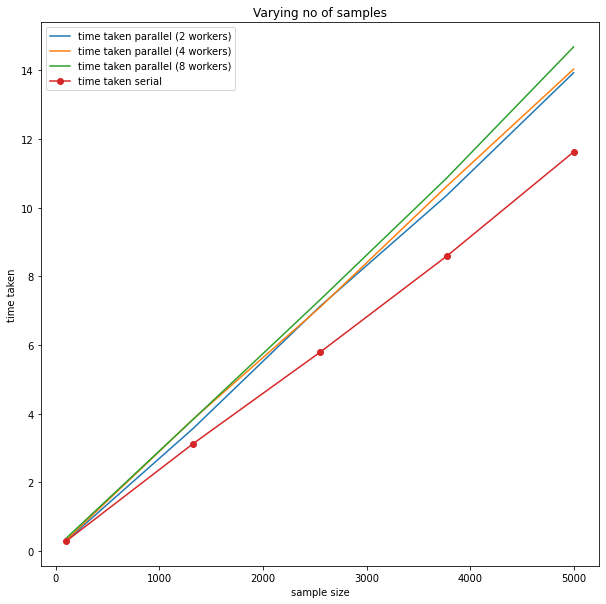

In [84]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken')
plt.title('Varying no of samples')

plt.show()

In [81]:
# serial function for bootstrap

df_time2 = pd.DataFrame(columns = ['sample size'])
df_time2['sample size'] = times

meanli = []
stdli = []

# changing sample size
perf = []
for b in times:
  perf.append(serial(b,1000))
df_time2['time taken serial'] = perf
df_time2

,sample size,time taken serial
0,100,2.539418
1,1325,2.704823
2,2550,2.778122
3,3775,2.839807
4,5000,3.118323


In [83]:
# parallel chaning sample size
for a in workers:
  p = []
  for b in times:
    p.append(parallel(b,1000,a))
  df_time2['time taken parallel ({} workers)'.format(a)] = p
df_time2

,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,2.539418,2.726081,2.858668,2.906806
1,1325,2.704823,2.841155,2.931636,3.066059
2,2550,2.778122,2.966020,3.000745,3.228825
3,3775,2.839807,3.062987,3.144115,3.313833
4,5000,3.118323,3.309184,3.445517,3.421595


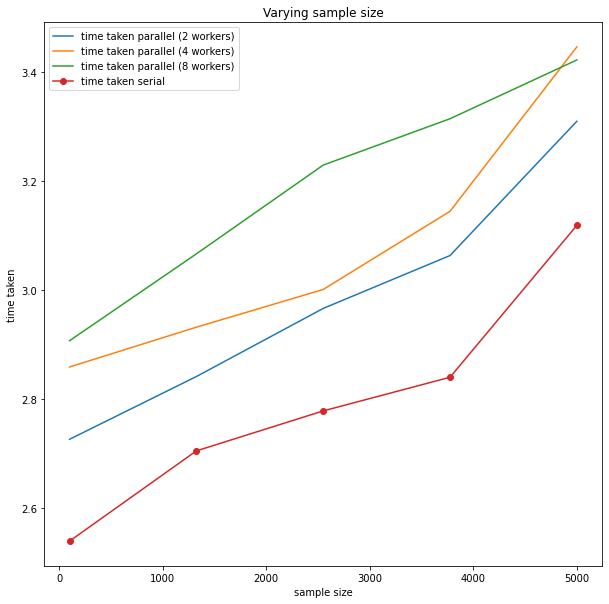

In [85]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time2, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time2, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken')
plt.title('Varying sample size')
plt.show()

In [ ]:
# performance over all samples

#need to take mean of all times 


plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time2, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time2, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken')
plt.title('Varying sample size')
plt.show()

We can now look at trying to parallelise a more computationally intensive problem by using bootstrapping to evaluate the accuracy of a model. We will use multiple processes to evaluate the model on a bootstrapped sample and return the mean accuracy.

In [95]:
#sampling and fitting the decision tree (but test set is the set not covered by the sampling) and return accuracy score

xx = df[df.columns[0:16]]; xy = df[df.columns[16]]

def g(n):
  big = list(xx.index)
  X = xx.sample(n=n,replace=True) # sample from training dataset
  ind = set(X.index)
  Y = xy.loc[list(X.index)]
  rest = [x for x in big if x not in ind]
  xt = xx.loc[rest]
  yt = xy.loc[rest]
  clf = tree.DecisionTreeClassifier().fit(X,Y).predict(xt)
  return(accuracy_score(clf,yt))

df_time3 = pd.DataFrame(columns = ['sample size'])
df_time3['sample size'] = times


0.5648015303682449

In [121]:
# serial function model evaluation

accuracy = []

# n = sample size; m = no of samples
def serial2(n,m):
  st = time.perf_counter()

  meanacc = []
  for a in range(m):
    meanacc.append(g(n))
  accuracy.append(np.mean(meanacc))
  en = time.perf_counter()
  return(en-st)

# changing no of samples

perf = []
for b in times:
  perf.append(serial2(100,b))
df_time3['time taken serial'] = perf
df_time3

,sample size,time taken serial
0,100,0.538044
1,1325,7.119575
2,2550,13.515882
3,3775,20.166199
4,5000,26.803534


In [100]:
accuracy

[0.7246745639532288,
 0.7252281030329658,
 0.7257015542578645,
 0.726144473351405,
 0.7258509266571217]

In [122]:
# parallel function model evaluation

acc = []
def parallel2(n,m,w):

  #n is how large each sample is, m is how many samples are taken
  inputs = [n]*m
  start = time.perf_counter()

  if __name__ == "__main__":
    #uses current.futures module instead of multiprocessing
    with cf.ProcessPoolExecutor(max_workers = w) as ex:
            #timing
      

            #uses map to map the function to the inputs and put into results list
      results = ex.map(g, inputs)
      #returns a generator object which we need to convert to a list
      pred = np.mean([x for x in results])

      acc.append(pred)
    finish = time.perf_counter()

            #time taken
    t = finish - start
    return(t)

# changing no of samples

for a in workers:
  p = []
  for b in times:
    p.append(parallel2(100,b,a))
  df_time3['time taken parallel ({} workers)'.format(a)] = p
df_time3

,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,0.538044,0.529332,0.563659,0.638743
1,1325,7.119575,6.178336,6.484825,7.463847
2,2550,13.515882,11.855005,12.394830,12.865630
3,3775,20.166199,17.655988,18.546995,19.004205
4,5000,26.803534,23.539605,24.269945,25.024302


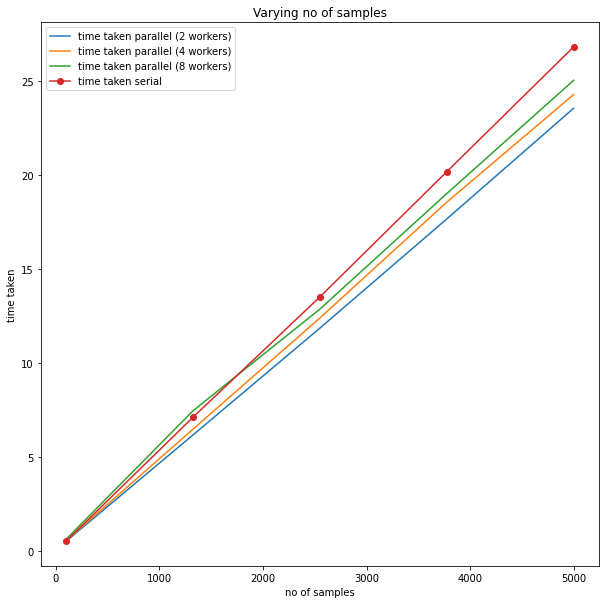

In [123]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time3, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time3, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('no of samples'); plt.ylabel('time taken')
plt.title('Varying no of samples')
plt.show()

We can see that using multiple processes simultaneously leads to better performance, with the difference in time taken between the serial and parallel function increasing as the number of samples increases.

In [119]:
# vary sample size
df_time3 = pd.DataFrame(columns = ['sample size'])
df_time3['sample size'] = times

df_time4['time taken serial'] = perf
df_time4

,sample size,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers),time taken serial
0,100,4.789362,4.983405,5.435045,5.235658
1,1325,6.829925,7.220763,7.870072,8.212111
2,2550,9.017279,9.416946,9.685694,11.337646
3,3775,11.167746,11.530614,11.755410,13.930077
4,5000,13.305419,13.940355,13.797630,16.555713


In [116]:
# vary no of samples

for a in workers:
  p = []
  for b in times:
    p.append(parallel2(b,1000,a))
  df_time4['time taken parallel ({} workers)'.format(a)] = p
df_time4

,sample size,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,4.789362,4.983405,5.435045
1,1325,6.829925,7.220763,7.870072
2,2550,9.017279,9.416946,9.685694
3,3775,11.167746,11.530614,11.755410
4,5000,13.305419,13.940355,13.797630


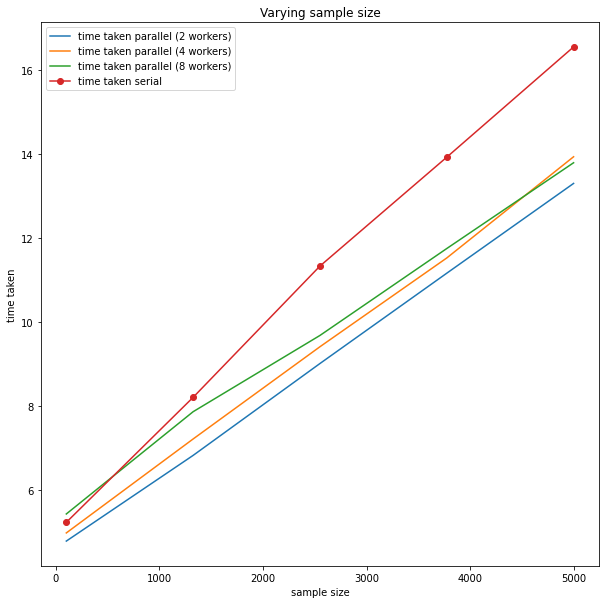

In [120]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time4, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time4, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken')
plt.title('Varying sample size')
plt.show()